## Goal:

[MAGIC](https://www.cell.com/action/showPdf?pii=S0092-8674%2818%2930724-4) provides a cool & fast way of denoising data, especially for rare words/genes, by borrowing information across cells. It may help my task ([challenge](https://zihao12.github.io/pyJSMF-RAW/issues_finding_anchor_word)) here, in two ways below:

### Apply MAGIC TO $X$
Denoising, particularly for rare genes. Hope is by borrowing info from similar cells, we can get better vector for rare genes

### Apply MAGIC to $X^T$
Not standard usage. We hope to achieve shrinkage. We form a similarity measure between genes, and use this to form a transition matrix, then multiply to  shrink the original matrix (though it seems the transition matrix ia what we want)

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize
import magic
import scprep


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
# %matplotlib widget

In [2]:
%%capture

## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
file = open(f'{datadir}/improve_C2.pkl', 'rb')
out = pickle.load(file)
file.close()

X = fitted['X'].toarray()
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']


Pi_true = Ltrue @ Ftrue.T
Pi_eb = out["Pi"]
AB = out["AB"]
n, p = X.shape

# truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n
S0, _, _ = findS(Cbar0, k)

## naive Cbar
Cbar1 = C / C.sum(axis = 1)[:, None] 
S1, _, _ = findS(Cbar1, k)

Cbar0_pj = pca_proj(Cbar0)
Cbar1_pj = pca_proj(Cbar1)


## MAGIC on $X$

In [3]:
X_normalized = scprep.normalize.library_size_normalize(X)
X_normalized = scprep.transform.sqrt(X_normalized)
magic_op = magic.MAGIC()
magic_op.fit(X_normalized)
X_magic = magic_op.transform(X)

Running MAGIC on 3207 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.53 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.05 seconds.
  Calculating affinities...
  Calculated affinities in 1.50 seconds.
Calculated graph and diffusion operator in 4.09 seconds.
Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.13 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3188 seconds

[5971 1326 7218  455   23  959]
[4. 1. 1. 3. 4. 3.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


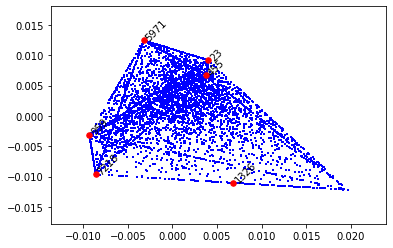

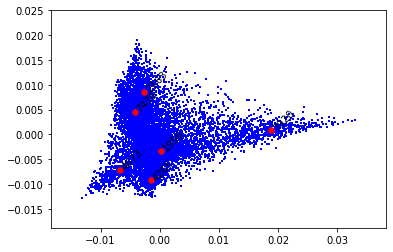

In [4]:
Pi_m = X_magic / X_magic.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X.sum(axis = 0)[S_m])
print(X.sum(axis = 0)[S0])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


### Comment

Algo still picks rare words, but they are closer to true anchor words (except for one)... as MAGIC makes even the rare words contain enough information

## MAGIC  on $X^T$

In [5]:
Y_normalized = scprep.normalize.library_size_normalize(X.T)
Y_normalized = scprep.transform.sqrt(Y_normalized)
magic_op = magic.MAGIC()
magic_op.fit(Y_normalized)
Y_magic = magic_op.transform(X.T)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.12 seconds.
  Calculating KNN search...
  Calculated KNN search in 10.40 seconds.
  Calculating affinities...
  Calculated affinities in 9.38 seconds.
Calculated graph and diffusion operator in 20.92 seconds.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.48 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2029 seconds

[8694 7914 4892 3416 7976 3038]
[ 253. 2723.  224.  378.  247.  246.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


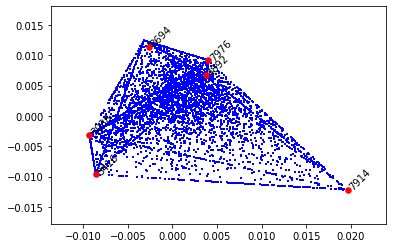

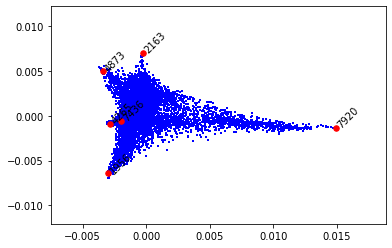

In [6]:
Pi_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
C_m = Pi_m.T @ Pi_m / n
Cbar_m = C_m / C_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)

print(S_m)
print(X.sum(axis = 0)[S_m])
print(X.sum(axis = 0)[S0])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_proj(Cbar_m), S0, which_dim = which_dim, annotate=True,fontsize=10)


### Comment:

* We find great anchor words!
* The shrinkage reveals the anchor words very well. Not sure if it's too aggressive
* There are tuning parameters we can play with (likle $t$)